In [1]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from finance.utilities import utils
from finance.science.utilities import lstm_utils, modeling_utils, options_utils, science_utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '2010-01-01'
date_end = '2020-06-20'
query = f'''
    with 
    tickers as (
        select distinct 
              ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where   ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker in ('KO')
        limit 30
        )
    , lagged as (
        select
              s.symbol
            , s.market_datetime
            , max(s.open) over (partition by s.symbol order by s.market_datetime rows between 1 following and 31 following) as target_max_open
            , s.open
            , lag(s.open, 1) over (partition by s.symbol order by s.market_datetime) as open_1
            , lag(s.open, 2) over (partition by s.symbol order by s.market_datetime) as open_2
            , lag(s.open, 3) over (partition by s.symbol order by s.market_datetime) as open_3
            , lag(s.open, 4) over (partition by s.symbol order by s.market_datetime) as open_4
            , lag(s.open, 5) over (partition by s.symbol order by s.market_datetime) as open_5
            , lag(s.open, 6) over (partition by s.symbol order by s.market_datetime) as open_6
            , lag(s.open, 7) over (partition by s.symbol order by s.market_datetime) as open_7
            , lag(s.open, 8) over (partition by s.symbol order by s.market_datetime) as open_8
            , lag(s.open, 9) over (partition by s.symbol order by s.market_datetime) as open_9
            , lag(s.open, 10) over (partition by s.symbol order by s.market_datetime) as open_10
            , lag(s.open, 11) over (partition by s.symbol order by s.market_datetime) as open_11
            , lag(s.open, 12) over (partition by s.symbol order by s.market_datetime) as open_12
            , lag(s.open, 13) over (partition by s.symbol order by s.market_datetime) as open_13
            , lag(s.open, 14) over (partition by s.symbol order by s.market_datetime) as open_14
            , lag(s.open, 15) over (partition by s.symbol order by s.market_datetime) as open_15
            , lag(s.open, 16) over (partition by s.symbol order by s.market_datetime) as open_16
            , lag(s.open, 17) over (partition by s.symbol order by s.market_datetime) as open_17
            , lag(s.open, 18) over (partition by s.symbol order by s.market_datetime) as open_18
            , lag(s.open, 19) over (partition by s.symbol order by s.market_datetime) as open_19
            , lag(s.open, 20) over (partition by s.symbol order by s.market_datetime) as open_20
            , lag(s.open, 21) over (partition by s.symbol order by s.market_datetime) as open_21
            , lag(s.open, 22) over (partition by s.symbol order by s.market_datetime) as open_22
            , lag(s.open, 23) over (partition by s.symbol order by s.market_datetime) as open_23
            , lag(s.open, 24) over (partition by s.symbol order by s.market_datetime) as open_24
            , lag(s.open, 25) over (partition by s.symbol order by s.market_datetime) as open_25
            , lag(s.open, 26) over (partition by s.symbol order by s.market_datetime) as open_26
            , lag(s.open, 27) over (partition by s.symbol order by s.market_datetime) as open_27
            , lag(s.open, 28) over (partition by s.symbol order by s.market_datetime) as open_28
            , lag(s.open, 29) over (partition by s.symbol order by s.market_datetime) as open_29
            , lag(s.open, 30) over (partition by s.symbol order by s.market_datetime) as open_30
        from td.stocks as s
        inner join tickers as t
            on t.ticker = s.symbol
        where s.market_datetime > '{date_start}' and s.market_datetime < '{date_end}'
        )
    , summarized as (
        select *
            , least(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_min
            , greatest(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_max
        from lagged
        where open_30 is not null
        )
    select
              symbol
            , market_datetime
            , target_max_open
            , open
            , open_min
            , open_max
            , (target_max_open - open_min) / (open_max - open_min) as normalized_open
            , (open_1 - open_min) / (open_max - open_min) as open_1
            , (open_2 - open_min) / (open_max - open_min) as open_2
            , (open_3 - open_min) / (open_max - open_min) as open_3
            , (open_4 - open_min) / (open_max - open_min) as open_4
            , (open_5 - open_min) / (open_max - open_min) as open_5
            , (open_6 - open_min) / (open_max - open_min) as open_6
            , (open_7 - open_min) / (open_max - open_min) as open_7
            , (open_8 - open_min) / (open_max - open_min) as open_8
            , (open_9 - open_min) / (open_max - open_min) as open_9
            , (open_10 - open_min) / (open_max - open_min) as open_10
            , (open_11 - open_min) / (open_max - open_min) as open_11
            , (open_12 - open_min) / (open_max - open_min) as open_12
            , (open_13 - open_min) / (open_max - open_min) as open_13
            , (open_14 - open_min) / (open_max - open_min) as open_14
            , (open_15 - open_min) / (open_max - open_min) as open_15
            , (open_16 - open_min) / (open_max - open_min) as open_16
            , (open_17 - open_min) / (open_max - open_min) as open_17
            , (open_18 - open_min) / (open_max - open_min) as open_18
            , (open_19 - open_min) / (open_max - open_min) as open_19
            , (open_20 - open_min) / (open_max - open_min) as open_20
            , (open_21 - open_min) / (open_max - open_min) as open_21
            , (open_22 - open_min) / (open_max - open_min) as open_22
            , (open_23 - open_min) / (open_max - open_min) as open_23
            , (open_24 - open_min) / (open_max - open_min) as open_24
            , (open_25 - open_min) / (open_max - open_min) as open_25
            , (open_26 - open_min) / (open_max - open_min) as open_26
            , (open_27 - open_min) / (open_max - open_min) as open_27
            , (open_28 - open_min) / (open_max - open_min) as open_28
            , (open_29 - open_min) / (open_max - open_min) as open_29
            , (open_30 - open_min) / (open_max - open_min) as open_30
    from summarized
    where target_max_open is not null
    order by market_datetime, symbol
    '''

df = utils.query_db(query=query)
df = df[~df.isna()]
df.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_21,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30
0,KO,2010-02-17,27.90,27.41,26.62,28.58,0.653061,0.326531,0.173469,0.091837,...,0.948980,0.969388,0.923469,0.729592,0.489796,0.566327,0.790816,0.795918,0.923469,1.000000
1,KO,2010-02-18,27.90,27.58,26.62,28.52,0.673684,0.415789,0.336842,0.178947,...,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789,0.821053,0.952632
2,KO,2010-02-19,27.90,27.90,26.62,28.52,0.673684,0.505263,0.415789,0.336842,...,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789,0.821053
3,KO,2010-02-22,27.78,27.90,26.62,28.52,0.610526,0.673684,0.505263,0.415789,...,0.610526,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789
4,KO,2010-02-23,27.78,27.71,26.62,28.52,0.610526,0.673684,0.673684,0.505263,...,0.294737,0.610526,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211


### Clean data

In [3]:
SYMBOL = 'symbol'

OPEN = 'open'
OPEN_MIN = 'open_min'
OPEN_MAX = 'open_max'
NORMALIZED_OPEN = 'normalized_open'

TARGET_MAX_OPEN = 'target_max_open'

COLS_TO_IGNORE = [SYMBOL, 'market_datetime', TARGET_MAX_OPEN, OPEN, OPEN_MIN, OPEN_MAX, NORMALIZED_OPEN]

In [4]:
df = science_utils.encode_one_hot(df, [SYMBOL])
df.head(10)

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_KO
0,KO,2010-02-17,27.90,27.41,26.62,28.58,0.653061,0.326531,0.173469,0.091837,...,0.969388,0.923469,0.729592,0.489796,0.566327,0.790816,0.795918,0.923469,1.000000,1
1,KO,2010-02-18,27.90,27.58,26.62,28.52,0.673684,0.415789,0.336842,0.178947,...,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789,0.821053,0.952632,1
2,KO,2010-02-19,27.90,27.90,26.62,28.52,0.673684,0.505263,0.415789,0.336842,...,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789,0.821053,1
3,KO,2010-02-22,27.78,27.90,26.62,28.52,0.610526,0.673684,0.505263,0.415789,...,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,0.815789,1
4,KO,2010-02-23,27.78,27.71,26.62,28.52,0.610526,0.673684,0.673684,0.505263,...,0.610526,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,0.584211,1
5,KO,2010-02-24,27.78,27.50,26.62,28.52,0.610526,0.573684,0.673684,0.673684,...,0.294737,0.610526,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,0.505263,1
6,KO,2010-02-25,27.78,26.57,26.62,28.52,0.610526,0.463158,0.573684,0.673684,...,0.331579,0.294737,0.610526,0.768421,0.784211,0.978947,1.000000,0.952632,0.752632,1
7,KO,2010-02-26,27.78,26.55,26.57,28.52,0.620513,0.000000,0.476923,0.584615,...,0.241026,0.348718,0.312821,0.620513,0.774359,0.789744,0.979487,1.000000,0.953846,1
8,KO,2010-03-01,27.78,26.61,26.55,28.52,0.624365,0.000000,0.010152,0.482234,...,0.228426,0.248731,0.355330,0.319797,0.624365,0.776650,0.791878,0.979695,1.000000,1
9,KO,2010-03-02,27.78,26.69,26.55,28.48,0.637306,0.031088,0.000000,0.010363,...,0.419689,0.233161,0.253886,0.362694,0.326425,0.637306,0.792746,0.808290,1.000000,1


### Train lstm

In [5]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

Batch 1, Epoch 0, Loss 869.4977416992188
Batch 1, Epoch 25, Loss 784.3836059570312
Batch 1, Epoch 50, Loss 513.9073486328125
Batch 1, Epoch 75, Loss 355.005859375
Batch 1, Epoch 100, Loss 335.74591064453125
Batch 1, Epoch 125, Loss 330.6185302734375
Batch 1, Epoch 150, Loss 325.6914367675781
Batch 1, Epoch 175, Loss 321.9338684082031
Batch 1, Epoch 200, Loss 316.7215576171875
Batch 1, Epoch 225, Loss 313.8678894042969
Batch 2, Epoch 0, Loss 321.1910400390625
Batch 2, Epoch 25, Loss 286.49395751953125
Batch 2, Epoch 50, Loss 281.8531494140625
Batch 2, Epoch 75, Loss 280.21795654296875
Batch 2, Epoch 100, Loss 278.26300048828125
Batch 2, Epoch 125, Loss 276.0872802734375
Batch 2, Epoch 150, Loss 274.724365234375
Batch 2, Epoch 175, Loss 273.6771240234375
Batch 2, Epoch 200, Loss 272.21868896484375
Batch 2, Epoch 225, Loss 270.90167236328125


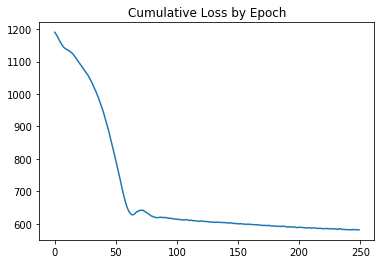

In [6]:
model = lstm_utils.TorchLSTM(
    x=train.drop(COLS_TO_IGNORE, axis=1),
    y=train[NORMALIZED_OPEN],
    n_layers=2,
    n_training_batches=2,
    batch_size=650,
    n_epochs=250,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()

model.x = test.drop(COLS_TO_IGNORE, axis=1)
prediction = model.prediction_df

In [7]:
PREDICTION = 'prediction'
DENORMALIZED_PREDICTION = 'denormalized_prediction'

res = test[COLS_TO_IGNORE].join(prediction)

res[DENORMALIZED_PREDICTION] = res[PREDICTION] * (df[OPEN_MAX] - df[OPEN_MIN]) + df[OPEN_MIN]
res.head()

,symbol,market_datetime,target_max_open,open,open_min,open_max,normalized_open,open_1,open_2,open_3,...,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_KO,prediction,denormalized_prediction
1953,KO,2017-11-16,46.34,46.95,45.39,47.32,0.492228,1.000000,0.683938,0.626943,...,0.445596,0.305699,0.253886,0.108808,0.082902,0.000000,0.062176,1,1.245888,47.794564
1954,KO,2017-11-17,46.33,46.34,45.39,47.32,0.487047,0.808290,1.000000,0.683938,...,0.378238,0.445596,0.305699,0.253886,0.108808,0.082902,0.000000,1,1.314543,47.927069
1955,KO,2017-11-20,46.33,45.65,45.41,47.32,0.481675,0.486911,0.806283,1.000000,...,0.586387,0.371728,0.439791,0.298429,0.246073,0.099476,0.073298,1,1.226005,47.751670
1956,KO,2017-11-21,46.33,45.56,45.41,47.32,0.481675,0.125654,0.486911,0.806283,...,0.523560,0.586387,0.371728,0.439791,0.298429,0.246073,0.099476,1,0.999578,47.319193
1957,KO,2017-11-22,46.33,45.89,45.41,47.32,0.481675,0.078534,0.125654,0.486911,...,0.502618,0.523560,0.586387,0.371728,0.439791,0.298429,0.246073,1,0.813820,46.964396


### Evaluate predictions

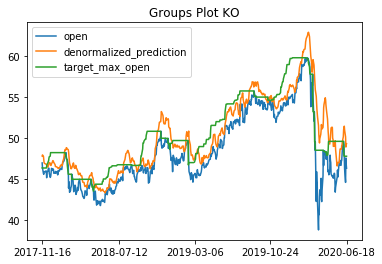

In [8]:
science_utils.plot_groups(res, SYMBOL, [OPEN, DENORMALIZED_PREDICTION, TARGET_MAX_OPEN])

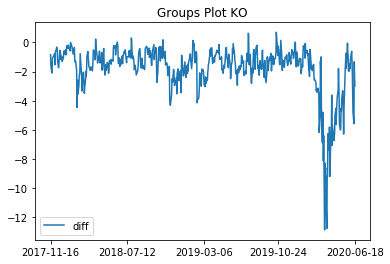

In [9]:
DIFF = 'diff'
res[DIFF] = res[OPEN] - res[DENORMALIZED_PREDICTION]
science_utils.plot_groups(res, SYMBOL, [DIFF])

### Get options data

In [10]:
date_start = datetime.datetime.today().date() - datetime.timedelta(days=2)
date_end = date_start
query = f'''
    with 
    stocks as (
      select
          market_datetime
        , symbol
        , close
      from td.stocks
      where market_datetime between '{date_start}' and '{date_end}'
          and symbol in ('KO', 'JPM' ,'AA')
      )
    , options as (
      select
          symbol
        , file_datetime
        , put_call = 'CALL'::text as put_call
        , strike
        , days_to_expiration
        , last
        , bid
        , ask
        , volatility
        , expiration_date_from_epoch
      from td.options
      where file_datetime between '{date_start}' and '{date_end}'
          and symbol in ('KO', 'JPM' ,'AA')
      )
    , volatility as (
      select
          symbol
        , file_datetime::date as file_datetime
        , strike
        , days_to_maturity
        , put_call::boolean
        , implied_volatility
      from td.black_scholes
      where file_datetime::date between '{date_start}' and '{date_end}'
          and symbol in ('KO', 'JPM' ,'AA')
      )
    , final as (
      select distinct
          s.market_datetime
        , s.symbol
        , s.close
        , o.put_call
        , o.strike
        , o.days_to_expiration as days_to_maturity
        , o.last
        , o.bid
        , o.ask
        , o.volatility
        , o.expiration_date_from_epoch
        , v.implied_volatility
        , avg(v.implied_volatility) over (partition by s.symbol) as avg_symbol_implied_volatility
        , dense_rank() over (order by s.symbol) as symbol_dr
      from stocks as s
      inner join options as o
        on  s.market_datetime = o.file_datetime
        and s.symbol = o.symbol
      left join volatility as v
        on  o.symbol = v.symbol
        and o.file_datetime = v.file_datetime
        and o.strike = v.strike
        and o.days_to_expiration = v.days_to_maturity
        and o.put_call = v.put_call
      order by
          s.market_datetime
        , s.symbol
        , o.put_call
        , o.strike
        , o.days_to_expiration
      )
    select *
          -- Average symbol implied volatility rank
        , 100 * dense_rank() over (order by avg_symbol_implied_volatility) / max(symbol_dr) over () as symbol_vol_rank
    from final
    '''

options = utils.query_db(query=query)
options.head()

,market_datetime,symbol,close,put_call,strike,days_to_maturity,last,bid,ask,volatility,expiration_date_from_epoch,implied_volatility,avg_symbol_implied_volatility,symbol_dr,symbol_vol_rank
0,2020-08-12,KO,48.43,False,47.5,23.0,0.50,0.55,0.71,29.0,2020-09-04 20:00:00,0.0,0.441494,3,33
1,2020-08-12,KO,48.43,False,47.5,16.0,0.38,0.38,0.45,29.0,2020-08-28 20:00:00,0.0,0.441494,3,33
2,2020-08-12,KO,48.43,False,47.5,9.0,0.25,0.24,0.30,29.0,2020-08-21 20:00:00,0.0,0.441494,3,33
3,2020-08-12,KO,48.43,False,47.5,2.0,0.06,0.05,0.07,29.0,2020-08-14 20:00:00,0.0,0.441494,3,33
4,2020-08-12,KO,48.43,False,47.0,156.0,2.50,2.47,2.59,29.0,2021-01-15 21:00:00,0.0,0.441494,3,33


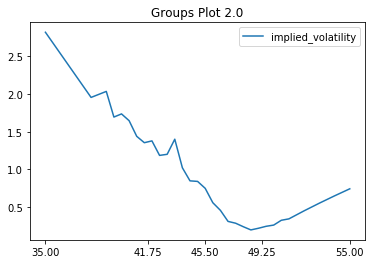

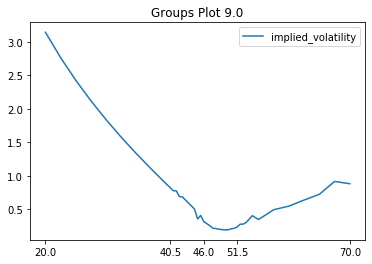

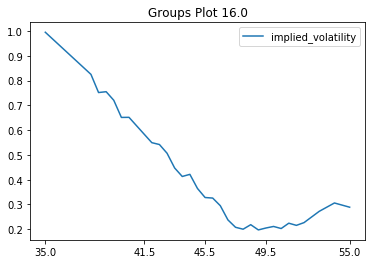

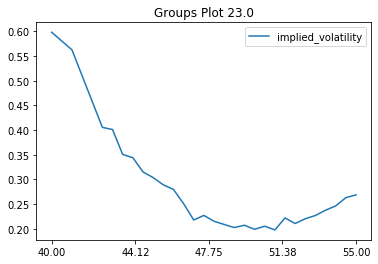

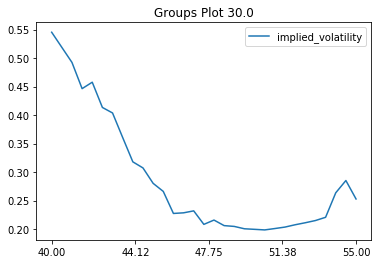

In [11]:
x = options[(options['put_call']) & (options['symbol']=='KO')]
science_utils.plot_groups(
    df=x,
    groups='days_to_maturity',
    lines=['implied_volatility'],
    xaxis_name='strike',
    n_plots=4,
)

### Determine options

In [12]:
vol_rankings = options[['symbol', 'symbol_vol_rank']].drop_duplicates()
vol_rankings

,symbol,symbol_vol_rank
0,KO,33
706,JPM,66
1772,AA,100
